In [1]:
import torch
import matplotlib.pyplot as plt
from time_series_course import plot_series, trend, seasonality, autocorrelation_one_step, noise

_ = torch.manual_seed(42)

### Generate synthetic time series (week 1)

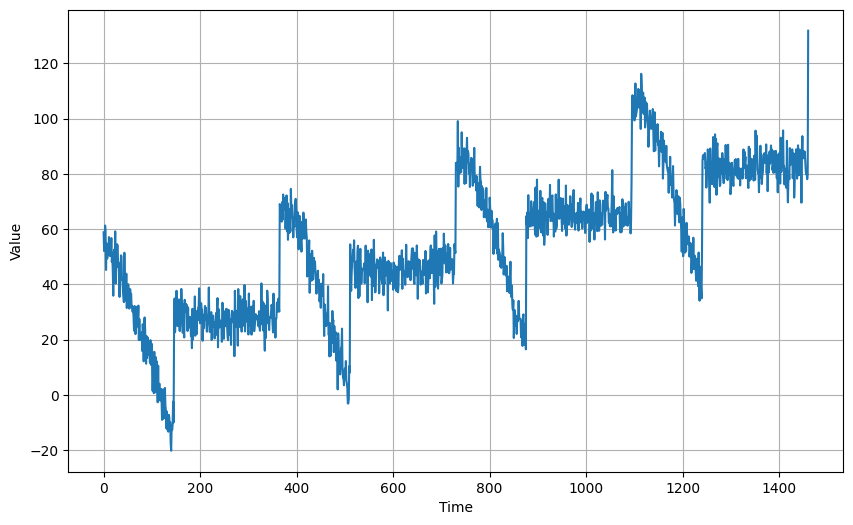

In [2]:
n_years = 4
include_autocorr = False

times = torch.arange(n_years * 365 + 1)

baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5
seas = 365
amplitude_autocorr = 5

series = (
    baseline
    + trend(times, slope)
    + seasonality(times, period=seas, amplitude=amplitude)
    + noise(times, noise_level, seed=0)
)

if include_autocorr:
    series += autocorrelation_one_step(times, amplitude_autocorr, seed=42)

plot_series(times, series)

### Simple forecasting techniques (week 1)

In [4]:
from time_series_course.preprocessing import fixed_partitioning
from time_series_course.forecasting import naive_fcast, mva_fcast

valid_size = 0.32  # select a split of around 1000 like in the course

t_train, s_train, t_valid, s_valid = fixed_partitioning(
    times, series, valid_size=valid_size
)

MAE on validation for naive method: 5.604219436645508
MAE on validation for MVA method: 6.133218765258789


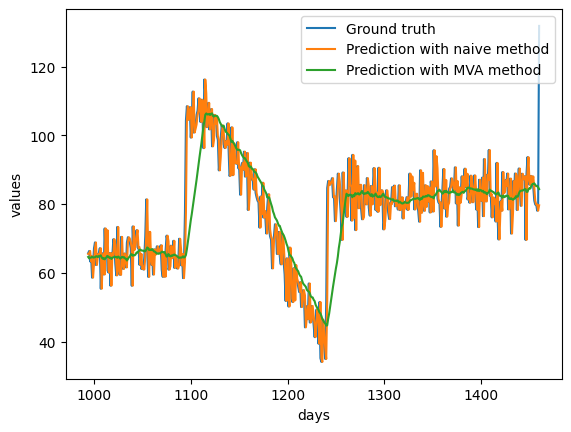

In [5]:
plt.figure()

mae_fn = torch.nn.L1Loss()

t_valid_np = t_valid.detach().numpy()
plt.plot(t_valid_np, s_valid.detach().numpy(), label=f"Ground truth")

# naive forecasting
_, fcast = naive_fcast(series, t_valid)
plt.plot(t_valid_np, fcast.detach().numpy(), label=f"Prediction with naive method")
print(f"MAE on validation for naive method: {mae_fn(fcast, s_valid).item()}")

# moving-average forecasting
window_size = 20
_, fcast = mva_fcast(series, t_valid, window_size=window_size)
plt.plot(t_valid_np, fcast.detach().numpy(), label=f"Prediction with MVA method")
print(f"MAE on validation for MVA method: {mae_fn(fcast, s_valid).item()}")

plt.ylabel("values")
plt.xlabel("days")
plt.legend()
plt.show()

### Windowed dataset for time series (week 2)

In [4]:
from time_series_course.preprocessing import windowed_dataloader

window_size = 20
batch_size = 16
dataloader = windowed_dataloader(series, window=window_size + 1, batch_size=batch_size)

for data in dataloader:
    assert len(data) == 2
    assert data[0].size(0) == data[1].size(0)
    assert data[0].size(1) == window_size

### Dense neural networks, recurrent neural networks and LSTMs (week 2 and 3)

In [5]:
from torch.optim.lr_scheduler import LinearLR

from time_series_course.models import Linear, RNN, LSTM, LSTMConv
from time_series_course.train import train_nn
from time_series_course.forecasting import nn_fcast

In [5]:
# hyperparameters
valid_size = 0.32
window_size = 20
batch_size = 16
n_epochs = 500
lr = 0.001
use_scheduler = False

In [6]:
t_train, s_train, t_valid, s_valid = fixed_partitioning(
    times, series, valid_size=valid_size
)

In [7]:
num_layers = 5
hidden_size = 5
models = {
    "DenseNN": Linear(seq_length=window_size, num_layers=num_layers, hidden_size=hidden_size),
    "RNN": RNN(seq_length=window_size, num_layers=num_layers, hidden_size=hidden_size),
    "LSTM": LSTM(seq_length=window_size, num_layers=num_layers, hidden_size=hidden_size, bidirectional=True),
}

In [8]:
# optimization configuration
loss_fn = torch.nn.HuberLoss

results = {}

model: torch.nn.Module
for name, model in models.items():
    print(f"Training {name} model")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if use_scheduler:
        scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=n_epochs*0.25)
    else:
        scheduler = None

    # training
    results[name] = train_nn(
        model,
        s_train,
        loss_fn=loss_fn,
        window_size=window_size,
        optimizer=optimizer,
        lr_scheduler=scheduler,
        n_epochs=n_epochs,
        batch_size=batch_size,
        printout=True,
    )
    print(f"-------------------")

Training DenseNN model
Loss at epoch 0: 2548.453125
Loss at epoch 100: 1172.794921875
Loss at epoch 200: 352.8367919921875
Loss at epoch 300: 341.3646240234375
Loss at epoch 400: 330.2872009277344
Loss at epoch 500: 265.6120300292969
-------------------
Training RNN model
Loss at epoch 0: 1200.3599853515625
Loss at epoch 100: 411.0486145019531
Loss at epoch 200: 266.107177734375
Loss at epoch 300: 260.4902648925781
Loss at epoch 400: 258.238525390625
Loss at epoch 500: 257.654052734375
-------------------
Training LSTM model
Loss at epoch 0: 4419.53955078125
Loss at epoch 100: 988.8358764648438
Loss at epoch 200: 474.5209655761719
Loss at epoch 300: 276.637939453125
Loss at epoch 400: 253.04127502441406
Loss at epoch 500: 245.96995544433594
-------------------


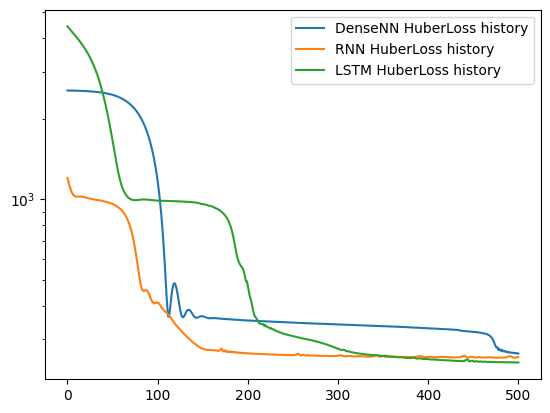

In [9]:
plt.figure()
plt.semilogy()
for name, res in results.items():
    plt.plot(res[1], label=f"{name} {loss_fn.__name__} history")
plt.legend()
plt.show()

MAE on validation for DenseNN: 5.122300624847412
MAE on validation for RNN: 5.1790876388549805
MAE on validation for LSTM: 5.953650951385498


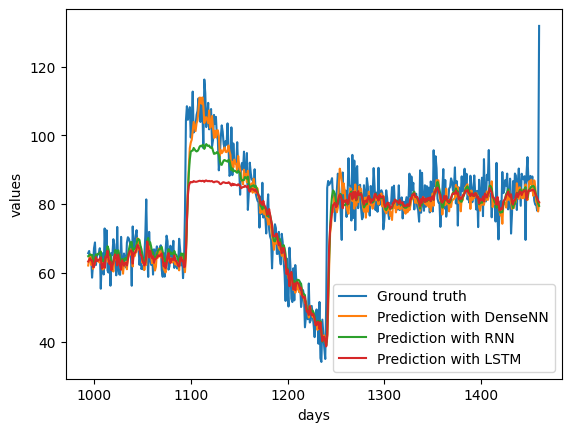

In [10]:
plt.figure()

t_valid_np = t_valid.detach().numpy()
plt.plot(t_valid_np, s_valid.detach().numpy(), label=f"Ground truth")

mae_fn = torch.nn.L1Loss()

for i, (name, result) in enumerate(results.items()):
    model = result[0]
    _, fcast = nn_fcast(series, t_valid, model, window_size=window_size)
    
    plt.plot(t_valid_np, fcast.detach().numpy(), label=f"Prediction with {name}")
    print(f"MAE on validation for {name}: {mae_fn(fcast, s_valid).item()}")

plt.ylabel("values")
plt.xlabel("days")
plt.legend()
plt.show()

### Predictions on real-world data adding CNNs (week 4)

In [6]:
import pandas as pd

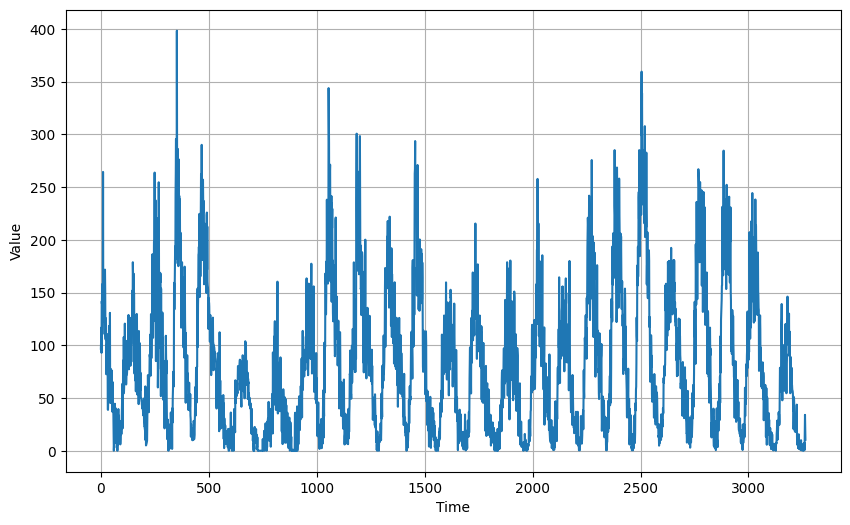

In [7]:
path_to_data = "./data/Sunspots.csv"
data = pd.read_csv(path_to_data)

times = torch.tensor(data.index).int()
series = torch.tensor(data["Monthly Mean Total Sunspot Number"]).float()

plot_series(times, series)

In [54]:
valid_size = 0.1
window_size = 30
batch_size = 100
n_epochs = 500
lr = 0.005

t_train, s_train, t_valid, s_valid = fixed_partitioning(times, series, valid_size=valid_size)

In [55]:
num_layers = 2
hidden_size = 5

model = LSTMConv(
    seq_length=window_size,
    num_layers=num_layers,
    hidden_size=hidden_size,
    bidirectional=True,
)

In [56]:
loss_fn = torch.nn.HuberLoss
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

trained_model, loss_history = train_nn(
        model,
        s_train,
        loss_fn=loss_fn,
        window_size=window_size,
        optimizer=optimizer,
        n_epochs=n_epochs,
        batch_size=batch_size,
        printout=True,
    )

Loss at epoch 0: 2573.95556640625
Loss at epoch 100: 592.8926391601562
Loss at epoch 200: 537.3093872070312
Loss at epoch 300: 522.2464599609375
Loss at epoch 400: 502.9501953125
Loss at epoch 500: 507.88726806640625


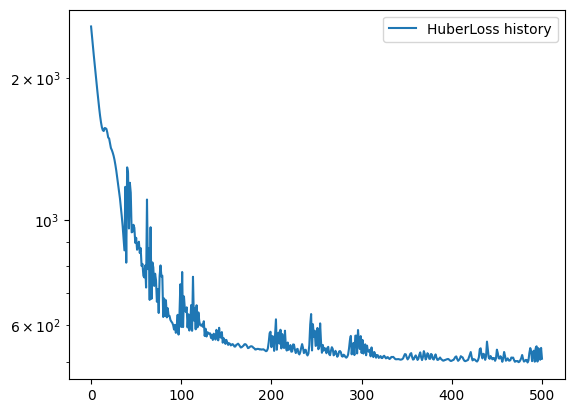

In [57]:
plt.figure()
plt.semilogy()
plt.plot(loss_history, label=f"{loss_fn.__name__} history")
plt.legend()
plt.show()

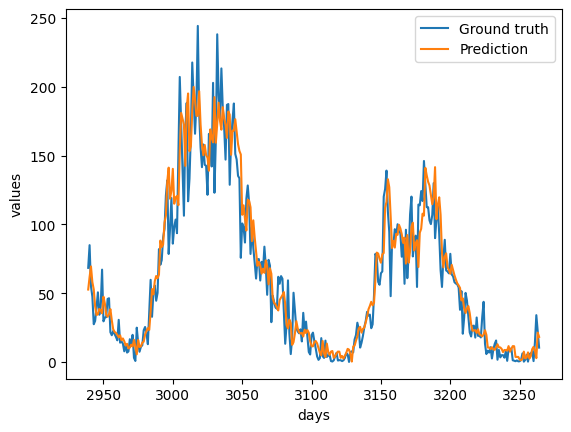

In [58]:
plt.figure()

t_valid_np = t_valid.detach().numpy()
plt.plot(t_valid_np, s_valid.detach().numpy(), label=f"Ground truth")

_, fcast = nn_fcast(series, t_valid, trained_model, window_size=window_size)
plt.plot(t_valid_np, fcast.detach().numpy(), label=f"Prediction")

plt.ylabel("values")
plt.xlabel("days")
plt.legend()
plt.show()

In [59]:
mae_fn = torch.nn.L1Loss()
print("Final MAE on validation: ", mae_fn(fcast, s_valid).item())

Final MAE on validation:  12.91720962524414
